<a href="https://colab.research.google.com/github/DannyTheFlower/PDA_Course/blob/main/practices/practice_3/PDA_P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных и их подготовка

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"daniilpiatygo","key":"6a5c15c37176a5dd0af08791f3882e69"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d arashnic/book-recommendation-dataset
!unzip -q book-recommendation-dataset.zip

 21% 5.00M/23.8M [00:00<00:00, 52.0MB/s]
100% 23.8M/23.8M [00:00<00:00, 133MB/s] 


In [ ]:
import numpy as np
import pandas as pd
import gc

In [ ]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

books = books.merge(ratings, on="ISBN").merge(users, on="User-ID")

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN


Удалим неиспользуемые переменные

In [ ]:
del ratings, users
gc.collect()

0

Значение 0 в столбце Book-Rating может иметь различные значения в зависимости от контекста и специфики данных. Наши гипотезы:

1. Отсутствие рейтинга.

2. Низкий рейтинг.

3. Ошибка или пропущенные данные.


In [ ]:
count_zero_ratings = len(books[books['Book-Rating'] == 0])
total_records = len(books)

percent_zero_ratings = (count_zero_ratings / total_records) * 100

print("Количество записей с Book-Rating равным 0:", count_zero_ratings)
print("Процент записей с Book-Rating равным 0:", percent_zero_ratings)

Количество записей с Book-Rating равным 0: 647294
Процент записей с Book-Rating равным 0: 62.77484250380163


В лабораторной работе мы решили не удалять 0 из датасета, но в рамках практической работы удалим записи, содержащие 0.

In [ ]:
books = books[books['Book-Rating'] != 0]
books.reset_index(drop=True, inplace=True)
books.shape

(383842, 12)

Чтобы решить проблему с нераспознанными странами в наборе данных, мы изменили обработку столбеца Location более тщательно. Видимо, иногда страна находится не на третьем, а на втором месте, особенно если регион не указан (например, 'ottawa, ,').

Прежде всего, мы точно знаем, что после split никогда не будет больше трех компонентов (город, регион, страна), нет необходимости удалять столбцы начиная с индекса 3.

In [ ]:
def parse_location(location):
    # Разделяем Location на части
    parts = [part.strip() for part in location.split(',')]

    # Длина списка parts может быть разной, в зависимости от того, как заполнен адрес
    if len(parts) > 2:
        # Если есть три или более части, то последняя - это страна
        country = parts[-1] if parts[-1] else None  # Обрабатываем пустые строки
        region = parts[-2] if len(parts) > 2 and parts[-2] else None
        city = parts[-3] if len(parts) > 2 and parts[-3] else None
    elif len(parts) == 2:
        # Если есть две части, то последняя часть - это страна, если она не пустая
        country = parts[-1] if parts[-1] else None
        region = None
        city = parts[0]
    else:
        # Если часть только одна, то это скорее всего город
        country = None
        region = None
        city = parts[0]

    return pd.Series([city, region, country], index=['city', 'region', 'country'])

In [ ]:
books[['city', 'region', 'country']] = books['Location'].apply(parse_location)

In [ ]:
books["Age"] = books["Age"].apply(lambda x: x if 0 <= x <= 100 else np.nan)

condition = (books["Year-Of-Publication"] == "Gallimard") | (books["Year-Of-Publication"] == "DK Publishing Inc")
books.loc[condition, ["Book-Author", "Year-Of-Publication"]] = books.loc[condition, ["Year-Of-Publication", "Book-Author"]].values

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,city,region,country
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,http://images.amazon.com/images/P/0887841740.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,http://images.amazon.com/images/P/1552041778.0...,8,5,"timmins, ontario, canada",NaN,timmins,ontario,canada
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,http://images.amazon.com/images/P/1567407781.0...,http://images.amazon.com/images/P/1567407781.0...,http://images.amazon.com/images/P/1567407781.0...,8,6,"timmins, ontario, canada",NaN,timmins,ontario,canada


Удалим неиспользуемые переменные

In [ ]:
del condition
gc.collect()

0

Посмотрим, что можно ещё сделать для обучения моделей.

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383842 entries, 0 to 383841
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 383842 non-null  object 
 1   Book-Title           383842 non-null  object 
 2   Book-Author          383841 non-null  object 
 3   Year-Of-Publication  383842 non-null  object 
 4   Publisher            383840 non-null  object 
 5   Image-URL-S          383842 non-null  object 
 6   Image-URL-M          383842 non-null  object 
 7   Image-URL-L          383841 non-null  object 
 8   User-ID              383842 non-null  int64  
 9   Book-Rating          383842 non-null  int64  
 10  Location             383842 non-null  object 
 11  Age                  268861 non-null  float64
 12  city                 383305 non-null  object 
 13  region               375056 non-null  object 
 14  country              373333 non-null  object 
dtypes: float64(1), in

Есть проблема с признаком `Year-Of-Publication`: его тип `object`, а не `int64`. Эту проблему мы решили во второй практической работе, поэтому просто преобразуем его к нужному типу.

In [ ]:
books["Year-Of-Publication"] = pd.to_numeric(books["Year-Of-Publication"])

Поработаем с категориальными признаками. В рамках данной практической работы мы не будем как-либо использовать ссылки на картинки, поэтому их просто удалим.

In [ ]:
books.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"], inplace=True)

Поработаем с пропусками. Признаки `Book-Author` и `Publisher` содержат в себе 1 и 2 пропуска соответственно — на весь массив данных это пренебрежительно малая часть, поэтому их можно удалить.

In [ ]:
books.dropna(subset=["Book-Author", "Publisher"], inplace=True)

`Age` имеет значительное количество пропусков. Заменим их на некоторое усреднённое: среднее или медиану. Посмотрим на распределение этого признака, чтобы выбрать более удачный вариант.

In [ ]:
books["Age"].describe()

count    268858.000000
mean         36.549175
std          12.450614
min           0.000000
25%          28.000000
50%          35.000000
75%          45.000000
max         100.000000
Name: Age, dtype: float64

Разница между средним и медианой в целом незначительна — почти 2 года при разбросе возрастов от 0 до 100. Остановимся на медиане.

In [ ]:
books["Age"] = books["Age"].fillna(books["Age"].median())

Также необходимо заполнить пропуски в столбце `country`. Посмотрим на несколько уникальных значений, которые были обработаны неправильно.

In [ ]:
books[books["country"].isna()]["Location"].unique()[:500]

array(['ottawa, ,', 'seattle, ,', 'albuquerque, ,', 'humble, ,',
       'aloha, ,', 'pearland, texas,', 'sarasota, ,',
       'west springfield, massachusetts,', 'west linn, ,',
       'north fort myers, ,', 'coconut grove, ,', 'mercer island, ,',
       'de soto, ,', 'vigo, pontevedra,', 'carmichael, ,', 'chicago, ,',
       'kuala lumpur, ,', 'tucson, ,', 'binghamton, ,',
       'yarmouth, nova scotia,', 'patterson lakes, ,',
       'manchester, new hampshire,', 'n/a, n/a,', 'cotati, ,',
       'tualatin, ,', 'managua, ,', 'san francisco, california,',
       'chesterfield, ,', 'brooklyn, new york,', 'llanelli, ,',
       'oxford, ,', 'anchorage, ,', 'molalla, ,', 'cincinnati, ,',
       'sahuarita, arizona,', 'fredericton, ,', 'cascade, ,',
       'vancouver, ,', 'bethel, ,', 'halifax, ,', 'arco, ,',
       'ne portland, oregon,', 'new bern, north carolina,',
       'monroe, new york,', 'crystal lake, ,', 'little falls, new york,',
       'altus, ,', 'houston, ,', 'san diego, ,', 'w

Чтобы заполнить пропуски в столбце country на основе значений в столбцах city и region, где возможно, можно сначала построить словарь, который будет хранить известные соответствия между городами/регионами и странами. Затем мы будем использовать этот словарь для заполнения пропусков.

In [ ]:
known_countries = {}
for index, row in books.iterrows():
    if not pd.isna(row['country']):
        known_countries[(row['city'], row['region'])] = row['country']

In [ ]:
known_countries

{('timmins', 'ontario'): 'canada',
 ('ottawa', 'ontario'): 'canada',
 ('n/a', 'n/a'): 'usa',
 ('toronto', 'ontario'): 'canada',
 ('victoria', 'british columbia'): 'canada',
 ('kingston', 'ontario'): 'canada',
 ('comber', 'ontario'): 'canada',
 ('guelph', 'ontario'): 'canada',
 ('halifax', 'nova scotia'): 'canada',
 ('fredericton', 'new brunswick'): 'canada',
 ('wichita', 'kansas'): 'usa',
 ('kansas city', 'missouri'): 'usa',
 ('oregon city', 'oregon'): 'usa',
 ('milpitas', 'california'): 'usa',
 ('medford', 'new york'): 'usa',
 ('denver', 'colorado'): 'usa',
 ('vacaville', 'california'): 'usa',
 ('indiana', 'pennsylvania'): 'usa',
 ('payson', 'arizona'): 'usa',
 ('columbus', 'ohio'): 'usa',
 ('knoxville', 'tennessee'): 'usa',
 ('raleigh', 'north carolina'): 'usa',
 ('san antonio', 'texas'): 'usa',
 ('loveland', 'colorado'): 'usa',
 ('seattle', 'washington'): 'usa',
 ('idaho falls', 'idaho'): 'usa',
 ('evanston', 'illinois'): 'usa',
 ('pleasanton', 'california'): 'usa',
 ('santa barbara

In [ ]:
def fill_missing_countries(row):
    if pd.isna(row['country']) and (row['city'], row['region']) in known_countries:
        return known_countries[(row['city'], row['region'])]
    else:
        return row['country']

In [ ]:
books['country'] = books.apply(fill_missing_countries, axis=1)

In [ ]:
len(books[books["country"].isna()]["Location"].unique())

876

Подавляющее большинство городов (в частности, по графику распределения стран из практической работы 2) относится к США — это самое часто встречающееся государство. Заполним пропуски модой.

In [ ]:
books["country"] = books["country"].fillna(books["country"].mode()[0])

Столбец `Location` нам больше не понадобится, можем его удалить.

In [ ]:
books.drop(columns=["Location"], inplace=True)

In [ ]:
books['city'] = books['city'].fillna('')
books['region'] = books['region'].fillna('')
books['country'] = books['country'].fillna('')

По данным Kaggle датасет был доступен с конца 2022 года. Для вычисления года рождения пользователей на основе их возраста, предполагая, что данные актуальны на конец 2022 года, мы можем использовать следующий подход:

In [ ]:
current_year = 2022
books['Birth Year'] = (current_year - books['Age'].round()).astype(int)

Рассчитаем разницу между годом рождения пользователя и годом публикации.
* Положительное число означает, что книга была издана до года рождения пользователя (т.е. пользователь младше книги).
* Отрицательное число означает, что книга была издана после года рождения пользователя (т.е. пользователь старше книги).
* Нуль означает, что пользователь и книга "одногодки" (год публикации книги совпадает с годом рождения пользователя).

In [ ]:
books['Publication_Age_Diff'] = books['Year-Of-Publication'] - books['Birth Year']


books[['Year-Of-Publication', 'Birth Year', 'Publication_Age_Diff']].head()

,Year-Of-Publication,Birth Year,Publication_Age_Diff
0,2001,1987,14
1,2002,1987,15
2,2004,1987,17
3,1999,1987,12
4,1998,1987,11


Cохраним информацию о том, старше ли пользователь книги или младше, в виде текстовой метки

In [ ]:
def age_comparison(diff):
    if diff > 0:
        return 'younger'
    elif diff < 0:
        return 'older'
    else:
        return 'same age'

In [ ]:
books['User_vs_Book_Age'] = books['Publication_Age_Diff'].apply(age_comparison)

In [ ]:
books[['Year-Of-Publication', 'Birth Year', 'Publication_Age_Diff', 'User_vs_Book_Age']].head()

,Year-Of-Publication,Birth Year,Publication_Age_Diff,User_vs_Book_Age
0,2001,1987,14,younger
1,2002,1987,15,younger
2,2004,1987,17,younger
3,1999,1987,12,younger
4,1998,1987,11,younger


In [ ]:
books.drop('Publication_Age_Diff', axis=1, inplace=True)

In [ ]:
books['Book-Author'].unique()[:20]

array(['Richard Bruce Wright', 'Ann Beattie', 'Sheila Heti',
       'R. J. Kaiser', 'Loren D. Estleman', 'Robert Hendrickson',
       'Julia Oliver', 'Mitch Albom', 'Yann Martel', 'Anita Diamant',
       'Anita Shreve', 'Jennifer Weiner', 'Joanne Harris',
       'David Baldacci', 'Anne Tyler', 'Nicholas Evans', 'Elizabeth Berg',
       'George Burns', 'D. H. Lawrence', 'Laura Zigman'], dtype=object)

Для определения пола автора по имени можно использовать библиотеку, которая распознает пол на основе имени. Одной из таких библиотек для Python является gender-guesser.

In [ ]:
!pip install gender-guesser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
import gender_guesser.detector as gender

d = gender.Detector(case_sensitive=False)

def get_gender(author_name):
    first_name = author_name.split()[0]
    return d.get_gender(first_name)

In [ ]:
books['Author_Gender'] = books['Book-Author'].apply(get_gender)

gender-guesser может не всегда корректно определять пол, особенно в случаях, когда имя является унисексовым, или если автор использует псевдоним. Результат работы будет включать категории 'male', 'female', 'mostlymale', 'mostlyfemale', 'andy' (андрогинный, неопределенный пол), и 'unknown' (неизвестно).

In [ ]:
books[['Book-Author', 'Author_Gender']].head()

,Book-Author,Author_Gender
0,Richard Bruce Wright,male
1,Ann Beattie,female
2,Sheila Heti,female
3,R. J. Kaiser,unknown
4,Loren D. Estleman,mostly_male


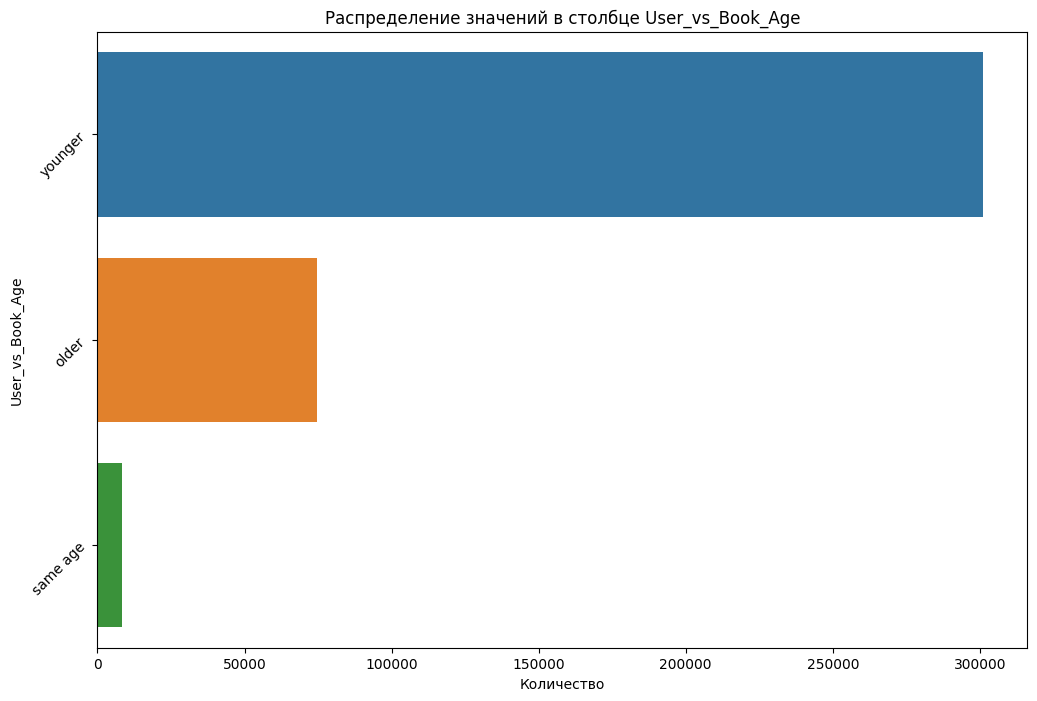

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
sns.countplot(data=books, y='User_vs_Book_Age', order=books['User_vs_Book_Age'].value_counts().index)
plt.title('Распределение значений в столбце User_vs_Book_Age')
plt.xlabel('Количество')
plt.ylabel('User_vs_Book_Age')
plt.yticks(rotation=45)
plt.show()

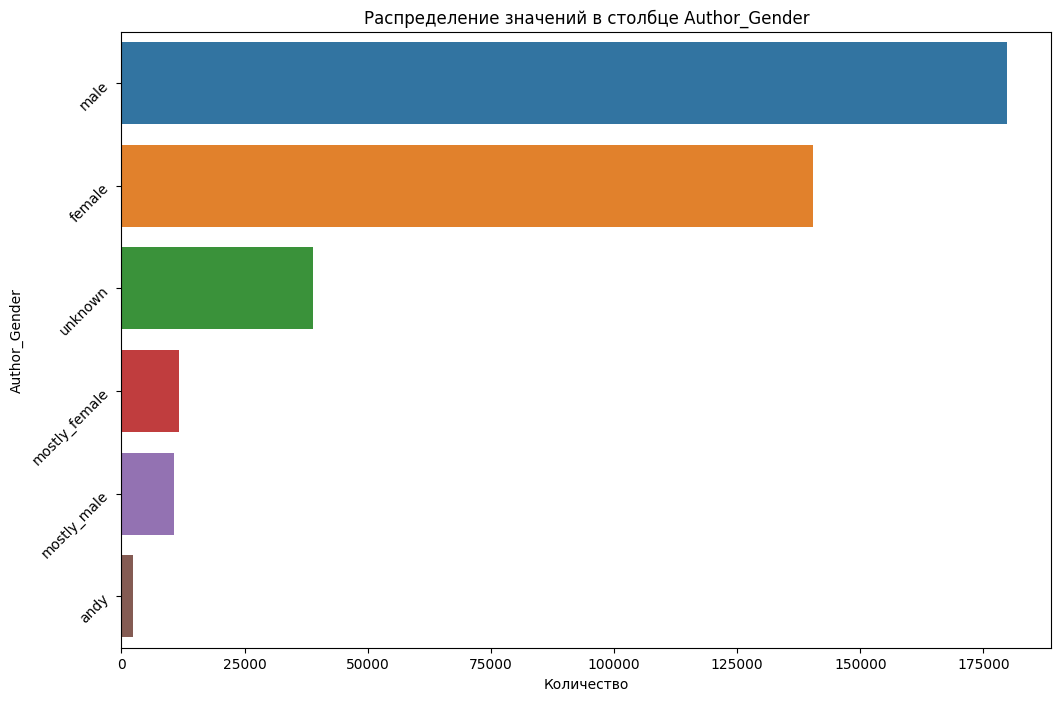

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
sns.countplot(data=books, y='Author_Gender', order=books['Author_Gender'].value_counts().index)
plt.title('Распределение значений в столбце Author_Gender')
plt.xlabel('Количество')
plt.ylabel('Author_Gender')
plt.yticks(rotation=45)
plt.show()

И, наконец, разделим для удобства числовые и категориальные признаки.

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,city,region,country,Birth Year,User_vs_Book_Age,Author_Gender
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5,35.0,timmins,ontario,canada,1987,younger,male
1,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,8,5,35.0,timmins,ontario,canada,1987,younger,female
2,0887841740,The Middle Stories,Sheila Heti,2004,House of Anansi Press,8,5,35.0,timmins,ontario,canada,1987,younger,female
3,1552041778,Jane Doe,R. J. Kaiser,1999,Mira Books,8,5,35.0,timmins,ontario,canada,1987,younger,unknown
4,1567407781,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,8,6,35.0,timmins,ontario,canada,1987,younger,mostly_male


In [ ]:
numeric_cols = [
    "Year-Of-Publication",
    "Birth Year",
    "User-ID",
    "Book-Rating",
    "Age",
]

categorial_cols = [
    "ISBN",
    "Book-Title",
    "Book-Author",
    "Publisher",
    "city",
    "region",
    "country",
    "User_vs_Book_Age",
    "Author_Gender"
]

# Нормировка числовых признаков

Для корректной работы некоторых моделей (например, KNN, нейронные сети) предварительно необходимо провести нормировку некоторых числовых признаков. Поскольку "истинно" числовыми являются признаки `Year-Of-Publication`, `Birth Year`,`Age`, будем нормировать именно их.

Из результатов второй практики видно, что распределение значений этих признаков похоже на нормальное, поэтому имеет смысл воспользоваться `StandardScaler`.

In [ ]:
from sklearn.preprocessing import StandardScaler

for col in ("Year-Of-Publication", "Age", "Birth Year"):
    books[col] = StandardScaler().fit_transform(books[col].values.reshape(-1, 1))

In [ ]:
books.to_csv('books_for_train.csv', index=False)

# Преобразование категориальных признаков и обучение моделей

Для преобразования категориальных данных в числовые признаки, в том числе названий книг, мы выбрали несколько подходов, такие как Bag of Words, TF-IDF, Word2Vec. Давайте рассмотрим каждый из них.

## Bag of Words

**bag-of-words - подход, при котором текст представляется в матрицы (количества вхождений слов в документы).**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_isbn = CountVectorizer(max_features=50)
vectorizer_title = CountVectorizer(max_features=50, stop_words='english')
vectorizer_author = CountVectorizer(max_features=50)
vectorizer_publisher = CountVectorizer(max_features=50)
vectorizer_city = CountVectorizer(max_features=50)
vectorizer_region = CountVectorizer(max_features=50)
vectorizer_country = CountVectorizer(max_features=50)
vectorizer_user_vs_book_age = CountVectorizer(max_features=50)
vectorizer_author_gender = CountVectorizer(max_features=50)

isbn_bow = vectorizer_isbn.fit_transform(books['ISBN'])
title_bow = vectorizer_title.fit_transform(books['Book-Title'])
author_bow = vectorizer_author.fit_transform(books['Book-Author'])
publisher_bow = vectorizer_publisher.fit_transform(books['Publisher'])
city_bow = vectorizer_city.fit_transform(books['city'])
region_bow = vectorizer_region.fit_transform(books['region'])
country_bow = vectorizer_country.fit_transform(books['country'])
user_vs_book_age_bow = vectorizer_user_vs_book_age.fit_transform(books['User_vs_Book_Age'])
author_gender_bow = vectorizer_author_gender.fit_transform(books['Author_Gender'])

Объединим преобразованные категориальные признаки с существующими числовыми и обучим модель на линейной регрессии, алгоритме случайного леса и `xgboost`. Качество модели будем оценивать с помощью меры `MSE`.

In [ ]:
isbn_df = pd.DataFrame(isbn_bow.toarray(), columns=vectorizer_isbn.get_feature_names_out())
title_df = pd.DataFrame(title_bow.toarray(), columns=vectorizer_title.get_feature_names_out())
author_df = pd.DataFrame(author_bow.toarray(), columns=vectorizer_author.get_feature_names_out())
publisher_df = pd.DataFrame(publisher_bow.toarray(), columns=vectorizer_publisher.get_feature_names_out())
city_df = pd.DataFrame(city_bow.toarray(), columns=vectorizer_city.get_feature_names_out())
region_df = pd.DataFrame(region_bow.toarray(), columns=vectorizer_region.get_feature_names_out())
country_df = pd.DataFrame(country_bow.toarray(), columns=vectorizer_country.get_feature_names_out())
user_vs_book_age_df = pd.DataFrame(user_vs_book_age_bow.toarray(), columns=vectorizer_user_vs_book_age.get_feature_names_out())
author_gender_df = pd.DataFrame(author_gender_bow.toarray(), columns=vectorizer_author_gender.get_feature_names_out())

df = pd.concat([books[numeric_cols], isbn_df, title_df, author_df, publisher_df, city_df, region_df, country_df,user_vs_book_age_df,author_gender_df ], axis=1)

del title_bow, author_bow, publisher_bow, city_bow, region_bow, country_bow, isbn_bow, user_vs_book_age_bow,author_gender_bow
del title_df, author_df, publisher_df, city_df, region_df, country_df ,user_vs_book_age_df,author_gender_df, isbn_df

gc.collect()  # вызываем сборщик мусора, чтобы освободить память

2943

Далее объединим столбцы с одинаковыми именами, которые возникли при объединении столбцов.

In [ ]:
duplicate_columns = df.columns[df.columns.duplicated(keep=False)]
combined_columns = {col: df.filter(like=col).sum(axis=1) for col in duplicate_columns}

df.drop(columns=duplicate_columns, inplace=True)

for col_name, col_values in combined_columns.items():
    df[col_name + "_combined"] = col_values

del duplicate_columns, combined_columns
gc.collect()

0

Разделим выборку на обучающую и тестовую.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Параметры train_test_split
random_state = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Book-Rating"]), df["Book-Rating"], test_size=test_size, random_state=random_state)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(y_train.mode()[0], inplace=True)
y_test.fillna(y_test.mode()[0], inplace=True)

del df
gc.collect()

0

## BoW + LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.349841732991181

## BoW + RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_RF = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1)
model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.193320220401464

## BoW + XGBoost

In [ ]:
import xgboost as xgb

model_XGB = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_XGB.fit(X_train, y_train)
y_pred = model_XGB.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.282001849704959

## TF-IDF

**tf–idf — это способ векторизации текста, отражающий важность слова в документе, а не только частоту его появления**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_isbn = TfidfVectorizer(max_features=50)
vectorizer_title = TfidfVectorizer(max_features=50, stop_words='english')
vectorizer_author = TfidfVectorizer(max_features=50)
vectorizer_publisher = TfidfVectorizer(max_features=50)
vectorizer_city = TfidfVectorizer(max_features=50)
vectorizer_region = TfidfVectorizer(max_features=50)
vectorizer_country = TfidfVectorizer(max_features=50)
vectorizer_user_vs_book_age = TfidfVectorizer(max_features=50)
vectorizer_author_gender = TfidfVectorizer(max_features=50)

isbn_tfidf = vectorizer_isbn.fit_transform(books['ISBN'])
title_tfidf = vectorizer_title.fit_transform(books['Book-Title'])
author_tfidf = vectorizer_author.fit_transform(books['Book-Author'])
publisher_tfidf = vectorizer_publisher.fit_transform(books['Publisher'])
city_tfidf = vectorizer_city.fit_transform(books['city'])
region_tfidf = vectorizer_region.fit_transform(books['region'])
country_tfidf = vectorizer_country.fit_transform(books['country'])
user_vs_book_age_tfidf = vectorizer_user_vs_book_age.fit_transform(books['User_vs_Book_Age'])
author_gender_tfidf = vectorizer_author_gender.fit_transform(books['Author_Gender'])

Аналогично преобразуем полученные векторы в датафреймы, объединим числовые и категориальные признаки, избавимся от повторов.

In [ ]:
isbn_df = pd.DataFrame(isbn_tfidf.toarray(), columns=vectorizer_isbn.get_feature_names_out())
title_df = pd.DataFrame(title_tfidf.toarray(), columns=vectorizer_title.get_feature_names_out())
author_df = pd.DataFrame(author_tfidf.toarray(), columns=vectorizer_author.get_feature_names_out())
publisher_df = pd.DataFrame(publisher_tfidf.toarray(), columns=vectorizer_publisher.get_feature_names_out())
city_df = pd.DataFrame(city_tfidf.toarray(), columns=vectorizer_city.get_feature_names_out())
region_df = pd.DataFrame(region_tfidf.toarray(), columns=vectorizer_region.get_feature_names_out())
country_df = pd.DataFrame(country_tfidf.toarray(), columns=vectorizer_country.get_feature_names_out())
user_vs_book_age_df = pd.DataFrame(user_vs_book_age_tfidf.toarray(), columns=vectorizer_user_vs_book_age.get_feature_names_out())
author_gender_df = pd.DataFrame(author_gender_tfidf.toarray(), columns=vectorizer_author_gender.get_feature_names_out())

df = pd.concat([books[numeric_cols], isbn_df, title_df, author_df, publisher_df, city_df, region_df, country_df,user_vs_book_age_df,author_gender_df ], axis=1)

del title_tfidf, author_tfidf, publisher_tfidf, city_tfidf, region_tfidf, country_tfidf, isbn_tfidf, user_vs_book_age_tfidf,author_gender_tfidf
del title_df, author_df, publisher_df, city_df, region_df, country_df ,user_vs_book_age_df,author_gender_df, isbn_df

gc.collect()  # вызываем сборщик мусора, чтобы освободить память

0

In [ ]:
duplicate_columns = df.columns[df.columns.duplicated(keep=False)]
combined_columns = {col: df.filter(like=col).sum(axis=1) for col in duplicate_columns}

df.drop(columns=duplicate_columns, inplace=True)

for col_name, col_values in combined_columns.items():
    df[col_name + "_combined"] = col_values

del duplicate_columns, combined_columns
gc.collect()

0

Разделим выборку на обучающую и тестовую и приступим к обучению моделей (как и раньше, `LinearRegression`, `RandomForestRegressor` и `XGBoostRegressor`).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Параметры train_test_split
random_state = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Book-Rating"]), df["Book-Rating"], test_size=test_size, random_state=random_state)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
y_train.fillna(y_train.mode()[0], inplace=True)
y_test.fillna(y_test.mode()[0], inplace=True)

del df
gc.collect()

0

## TF-IDF + LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.3474840104729773

## TF-IDF + RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, max_depth=15, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.1997290573017754

## TF-IDF + XGBoost

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.2900780262866522

## Word2Vec

**W2V — модель, которая фиксирует синтаксическое и семантическое сходство между словами, т.е. слова, близкие по значению, будут помещены рядом**

Обучим модель для каждого столбца и далее получим векторное представление для каждого значения категориального признака, усреднив векторы, полученные для данного значения с помощью Word2Vec (или, в случае отсутствия слов в модели, вернув нулевой вектор).

In [ ]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import numpy as np

vector_size = 50

w2v_models = dict()
for col in categorial_cols:
    w2v_models[col] = Word2Vec([str(value).split() for value in books[col].unique()],
                               vector_size=vector_size, window=5, min_count=1, workers=4)

In [ ]:
def vectorize_and_average(model, value):
    """
    Возвращает средний вектор для набора слов или нулевой вектор той же
    размерности, если ни одного слов нет в словаре модели
    """
    words = str(value).split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(model.vector_size)

df_vectorized = pd.DataFrame()

for col in categorial_cols:
    df_vectorized[col] = books[col].apply(lambda x: vectorize_and_average(w2v_models[col], x))

# далее "распрямим" векторы: пусть каждая координата стоит в отдельном столбце
for col in categorial_cols:
    col_vectors = pd.DataFrame(df_vectorized[col].tolist(), columns=[f"{col}_{i+1}" for i in range(vector_size)])
    df_vectorized = df_vectorized.drop(col, axis=1)
    df_vectorized = pd.concat([df_vectorized, col_vectors], axis=1)
    df_vectorized.dropna(inplace=True)

In [ ]:
df = pd.concat([books[numeric_cols], df_vectorized], axis=1)
del df_vectorized, books
gc.collect()

0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Параметры train_test_split
random_state = 42
test_size = 0.2

df.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["Book-Rating"]), df["Book-Rating"],
    test_size=test_size, random_state=random_state)

del df
gc.collect()

0

## Word2Vec + LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.399567499967432

## Word2Vec + RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=30, max_depth=10, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.2032359339786094

## Word2Vec + XGBoost

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: round(x), y_pred))

mean_squared_error(y_pred, y_test)

3.243476674960593

Наиболее удачной при обновлённой предобработке является использование BoW + RandomForest  — эта комбинация даёт наименьшую среднеквадратическую ошибку - примерно 1.8 баллов из 10.

Результат можно улучшить, например, подобрав более удачные гиперпараметры RandomForest, увеличив размер вектора Word2Vec. Однако, поскольку все 9 комбинаций дают примерно одинаковый результат, больший вклад даёт более качественная предобработка.

# ALS

In [ ]:
%%capture
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("ALSExample").getOrCreate()

In [ ]:
from pyspark.sql.types import IntegerType

data = spark.read.csv("Ratings.csv", header=True, inferSchema=True)
data = data.filter((col("Book-Rating") != 0) & (col("Book-Rating").isNotNull()))
data = data.withColumn("Book-Rating", col("Book-Rating").cast(IntegerType()))

In [ ]:
indexer = StringIndexer(inputCol="ISBN", outputCol="ISBN_encoded")
data = indexer.fit(data).transform(data)
indexer = StringIndexer(inputCol="User-ID", outputCol="User-ID_encoded")
data = indexer.fit(data).transform(data)

(training_data, test_data) = data.randomSplit([0.8, 0.2])

In [ ]:
als = ALS(userCol="User-ID_encoded", itemCol="ISBN_encoded", ratingCol="Book-Rating", nonnegative=True, coldStartStrategy="drop")
model = als.fit(training_data)

predictions = model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Book-Rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

In [ ]:
from pyspark.sql.functions import round, when

predictions = predictions.withColumn("prediction", round(col("prediction")))
predictions = predictions.withColumn("prediction", when(col("prediction") < 0, 0).when(col("prediction") > 10, 10).otherwise(col("prediction")))
evaluator = RegressionEvaluator(labelCol="Book-Rating", predictionCol="prediction", metricName="rmse")
rmse_rounded = evaluator.evaluate(predictions)

In [ ]:
predictions.select(
        'User-ID',
        'ISBN',
        'Book-Rating',
        'prediction'
).show()

+-------+----------+-----------+----------+
|User-ID|      ISBN|Book-Rating|prediction|
+-------+----------+-----------+----------+
|  35513|0971880107|          8|       4.0|
|  51803|0971880107|          1|       5.0|
| 148712|0971880107|          2|       3.0|
| 129851|0971880107|          1|       3.0|
|  50201|0971880107|          3|       3.0|
| 136237|0971880107|          2|       3.0|
| 128447|0971880107|          8|       5.0|
| 160431|0971880107|          5|       4.0|
| 157602|0971880107|          2|       3.0|
|  86123|0971880107|          4|       4.0|
|  13221|0971880107|          9|       4.0|
|  65258|0971880107|          6|       4.0|
|  79821|0971880107|          1|       4.0|
|  88693|0971880107|          4|       4.0|
| 125053|0971880107|          3|       2.0|
|  65145|0971880107|          5|       4.0|
|  42128|0971880107|          2|       4.0|
|  24664|0971880107|          8|       2.0|
| 165371|0971880107|          5|       2.0|
|  56399|0971880107|          5|

# SVD

In [ ]:
%%capture
!pip install scikit-surprise

In [ ]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

ratings_df = pd.read_csv('Ratings.csv', usecols=['User-ID', 'ISBN', 'Book-Rating'])
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(ratings_df[['User-ID', 'ISBN', 'Book-Rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.5007  3.5043  3.5026  3.5082  3.4874  3.5006  0.0071  
Fit time          41.44   28.20   26.95   28.65   27.35   30.52   5.50    
Test time         7.84    1.79    1.70    2.03    1.74    3.02    2.41    


{'test_rmse': array([3.50065007, 3.50432963, 3.50255578, 3.50818048, 3.48738795]),
 'fit_time': (41.444146156311035,
  28.19709300994873,
  26.952637672424316,
  28.650994539260864,
  27.353343725204468),
 'test_time': (7.835820436477661,
  1.7929081916809082,
  1.7043402194976807,
  2.027207612991333,
  1.7423961162567139)}

# Топ-5 рекомендаций для 5 рандомных пользователей

Выведем топ-5 рекомендаций для 5 рандомных пользователей.
Покажем все оценки: реальную, предсказанную через две модели коллаборативной фильтрации и через три модели, обученные в рамках лабораторной, а также среднюю оценку по всем предсказаниям (с одинаковыми или разными весами для каждой модели).

In [ ]:
books = pd.read_csv('books_for_train.csv')
user_data = books.sample(5)

In [ ]:
user_data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,city,region,country,Birth Year,User_vs_Book_Age,Author_Gender
245564,0440159695,Moss Rose,Day Taylor,0.059055,Dell,88677,8,0.757815,laval,quebec,canada,-0.757815,younger,unknown
191896,0765341581,The Dragon of Despair (Wolf),Jane Lindskold,0.157731,Tor Books,8864,8,-0.965604,st petersburg,florida,usa,0.965604,younger,female
239841,0679731148,A Year in Provence,Peter Mayle,0.104281,Vintage Books USA,211098,8,-0.103895,clarksville,tennessee,usa,0.103895,younger,male
293038,0385503954,Atonement: A Novel,Ian McEwan,0.149508,Nan A. Talese,42847,8,3.342944,las vegas,nevada,usa,-3.342944,younger,male
141760,015100692X,The Crimson Petal and the White,Michel Faber,0.149508,Harcourt,270554,9,-0.103895,fredericton,new brunswick,canada,0.103895,younger,male


Применим модели BoW+LR, RF, XGB для нашего сэмпла данных

In [ ]:
isbn_bow = vectorizer_isbn.transform(user_data['ISBN'])
title_bow = vectorizer_title.transform(user_data['Book-Title'])
author_bow = vectorizer_author.transform(user_data['Book-Author'])
publisher_bow = vectorizer_publisher.transform(user_data['Publisher'])
city_bow = vectorizer_city.transform(user_data['city'])
region_bow = vectorizer_region.transform(user_data['region'])
country_bow = vectorizer_country.transform(user_data['country'])
user_vs_book_age_bow = vectorizer_user_vs_book_age.transform(user_data['User_vs_Book_Age'])
author_gender_bow = vectorizer_author_gender.transform(user_data['Author_Gender'])

isbn_df = pd.DataFrame(isbn_bow.toarray(), columns=vectorizer_isbn.get_feature_names_out())
title_df = pd.DataFrame(title_bow.toarray(), columns=vectorizer_title.get_feature_names_out())
author_df = pd.DataFrame(author_bow.toarray(), columns=vectorizer_author.get_feature_names_out())
publisher_df = pd.DataFrame(publisher_bow.toarray(), columns=vectorizer_publisher.get_feature_names_out())
city_df = pd.DataFrame(city_bow.toarray(), columns=vectorizer_city.get_feature_names_out())
region_df = pd.DataFrame(region_bow.toarray(), columns=vectorizer_region.get_feature_names_out())
country_df = pd.DataFrame(country_bow.toarray(), columns=vectorizer_country.get_feature_names_out())
user_vs_book_age_df = pd.DataFrame(user_vs_book_age_bow.toarray(), columns=vectorizer_user_vs_book_age.get_feature_names_out())
author_gender_df = pd.DataFrame(author_gender_bow.toarray(), columns=vectorizer_author_gender.get_feature_names_out())

df = pd.concat([user_data[numeric_cols], isbn_df, title_df, author_df, publisher_df, city_df, region_df, country_df,user_vs_book_age_df,author_gender_df ], axis=1)

duplicate_columns = df.columns[df.columns.duplicated(keep=False)]
combined_columns = {col: df.filter(like=col).sum(axis=1) for col in duplicate_columns}

df.drop(columns=duplicate_columns, inplace=True)

for col_name, col_values in combined_columns.items():
    df[col_name + "_combined"] = col_values

if 'Book-Rating' in df.columns:
    df = df.drop('Book-Rating', axis=1)

df.fillna(0, inplace=True)

In [ ]:
import numpy as np

user_rating_pred_LR = model_LR.predict(df)

if isinstance(user_rating_pred_LR, pd.DataFrame):
    user_rating_pred_LR = user_rating_pred_LR.to_numpy().flatten()
elif isinstance(user_rating_pred_LR, pd.Series):
    user_rating_pred_LR = user_rating_pred_LR.to_numpy()

user_rating_pred_LR = np.round(user_rating_pred_LR)
user_rating_pred_LR = int(user_rating_pred_LR[0])

user_data['Predicted-Rating-LR'] = user_rating_pred_LR
user_data[["ISBN", "User-ID", "Book-Rating", "Predicted-Rating-LR"]]

,ISBN,User-ID,Book-Rating,Predicted-Rating-LR
0,0440159695,88677,8,8
1,0765341581,8864,8,8
2,0679731148,211098,8,8
3,0385503954,42847,8,8
4,015100692X,270554,9,8


In [ ]:
user_rating_pred_RF = model_RF.predict(df)
if isinstance(user_rating_pred_RF, pd.DataFrame):
    user_rating_pred_RF = user_rating_pred_RF.to_numpy().flatten()
elif isinstance(user_rating_pred_RF, pd.Series):
    user_rating_pred_RF = user_rating_pred_RF.to_numpy()
user_rating_pred_RF = np.round(user_rating_pred_RF)
user_rating_pred_RF = int(user_rating_pred_RF[0])
user_data['Predicted-Rating-RF'] = user_rating_pred_RF
user_data[["ISBN", "User-ID", "Book-Rating", "Predicted-Rating-RF"]]

,ISBN,User-ID,Book-Rating,Predicted-Rating-RF
0,0440159695,88677,8,8
1,0765341581,8864,8,8
2,0679731148,211098,8,8
3,0385503954,42847,8,8
4,015100692X,270554,9,8


In [ ]:
import numpy as np
user_rating_pred_XGB = model_XGB.predict(df)

if isinstance(user_rating_pred_XGB, pd.DataFrame):
    user_rating_pred_XGB = user_rating_pred_XGB.to_numpy().flatten()
elif isinstance(user_rating_pred_XGB, pd.Series):
    user_rating_pred_XGB = user_rating_pred_XGB.to_numpy()

user_rating_pred_XGB = np.round(user_rating_pred_XGB)
user_rating_pred_XGB = int(user_rating_pred_XGB[0])
user_data['Predicted-Rating-XGB'] = user_rating_pred_XGB
user_data[["ISBN", "User-ID", "Book-Rating", "Predicted-Rating-XGB"]]

,ISBN,User-ID,Book-Rating,Predicted-Rating-XGB
0,0440159695,88677,8,8
1,0765341581,8864,8,8
2,0679731148,211098,8,8
3,0385503954,42847,8,8
4,015100692X,270554,9,8


In [ ]:
user_data[["ISBN", "User-ID", "Book-Rating", "Predicted-Rating-LR", "Predicted-Rating-RF", "Predicted-Rating-XGB"]]

,ISBN,User-ID,Book-Rating,Predicted-Rating-LR,Predicted-Rating-RF,Predicted-Rating-XGB
0,0440159695,88677,8,8,8,8
1,0765341581,8864,8,8,8,8
2,0679731148,211098,8,8,8,8
3,0385503954,42847,8,8,8,8
4,015100692X,270554,9,8,8,8


Применим ALS для нашего сэмпла

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

user_data_spark = spark.createDataFrame(user_data)
user_data_spark = user_data_spark.withColumn("Book-Rating", col("Book-Rating").cast(IntegerType()))

indexer = StringIndexer(inputCol="ISBN", outputCol="ISBN_encoded")
user_data_spark = indexer.fit(user_data_spark).transform(user_data_spark)
indexer = StringIndexer(inputCol="User-ID", outputCol="User-ID_encoded")
user_data_spark = indexer.fit(user_data_spark).transform(user_data_spark)

predictions_user_data = model.transform(user_data_spark)

predictions_user_data = predictions_user_data.withColumn("prediction", round(col("prediction")))
predictions_user_data = predictions_user_data.withColumn("prediction", when(col("prediction") < 0, 0).when(col("prediction") > 10, 10).otherwise(col("prediction")))

result_user_data = predictions_user_data.select(
    'User-ID',
    'ISBN',
    'Book-Rating',
    'prediction'
)

result_user_data_pd = result_user_data.toPandas()
result_user_data_pd

,User-ID,ISBN,Book-Rating,prediction
0,42847,0385503954,8,5.0
1,211098,0679731148,8,7.0
2,270554,015100692X,9,8.0
3,88677,0440159695,8,7.0
4,8864,0765341581,8,6.0


In [ ]:
user_data = user_data.merge(
    result_user_data_pd[['User-ID', 'ISBN', 'prediction']],
    on=['User-ID', 'ISBN'],
    how='left'
).rename(columns={'prediction': 'Predicted-Rating-ALS'})

In [ ]:
user_data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,city,region,country,Birth Year,User_vs_Book_Age,Author_Gender,Predicted-Rating-LR,Predicted-Rating-RF,Predicted-Rating-XGB,Predicted-Rating-SVD,Predicted-Rating-ALS
0,0440159695,Moss Rose,Day Taylor,0.059055,Dell,88677,8,0.757815,laval,quebec,canada,-0.757815,younger,unknown,8,8,8,7.792406,7.0
1,0765341581,The Dragon of Despair (Wolf),Jane Lindskold,0.157731,Tor Books,8864,8,-0.965604,st petersburg,florida,usa,0.965604,younger,female,8,8,8,6.717503,6.0
2,0679731148,A Year in Provence,Peter Mayle,0.104281,Vintage Books USA,211098,8,-0.103895,clarksville,tennessee,usa,0.103895,younger,male,8,8,8,7.124341,7.0
3,0385503954,Atonement: A Novel,Ian McEwan,0.149508,Nan A. Talese,42847,8,3.342944,las vegas,nevada,usa,-3.342944,younger,male,8,8,8,7.304786,5.0
4,015100692X,The Crimson Petal and the White,Michel Faber,0.149508,Harcourt,270554,9,-0.103895,fredericton,new brunswick,canada,0.103895,younger,male,8,8,8,8.565305,8.0


Применим SVD для нашего сэмпла

In [ ]:
user_data

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Age,city,region,country,Birth Year,User_vs_Book_Age,Author_Gender,Predicted-Rating-LR,Predicted-Rating-RF,Predicted-Rating-XGB
0,0440159695,Moss Rose,Day Taylor,0.059055,Dell,88677,8,0.757815,laval,quebec,canada,-0.757815,younger,unknown,8,8,8
1,0765341581,The Dragon of Despair (Wolf),Jane Lindskold,0.157731,Tor Books,8864,8,-0.965604,st petersburg,florida,usa,0.965604,younger,female,8,8,8
2,0679731148,A Year in Provence,Peter Mayle,0.104281,Vintage Books USA,211098,8,-0.103895,clarksville,tennessee,usa,0.103895,younger,male,8,8,8
3,0385503954,Atonement: A Novel,Ian McEwan,0.149508,Nan A. Talese,42847,8,3.342944,las vegas,nevada,usa,-3.342944,younger,male,8,8,8
4,015100692X,The Crimson Petal and the White,Michel Faber,0.149508,Harcourt,270554,9,-0.103895,fredericton,new brunswick,canada,0.103895,younger,male,8,8,8


In [ ]:
predictions = []
for index, row in user_data.iterrows():
    prediction = algo.predict(row['User-ID'], row['ISBN'])
    predictions.append(prediction.est)

user_data['Predicted-Rating-SVD'] = predictions
user_data[['User-ID', 'ISBN', 'Book-Rating', 'Predicted-Rating-SVD']]

,User-ID,ISBN,Book-Rating,Predicted-Rating-SVD
0,88677,0440159695,8,7.792406
1,8864,0765341581,8,6.717503
2,211098,0679731148,8,7.124341
3,42847,0385503954,8,7.304786
4,270554,015100692X,9,8.565305


Найдём среднее

In [ ]:
user_data["AVG"] = user_data[["Book-Rating", "Predicted-Rating-LR", "Predicted-Rating-RF", "Predicted-Rating-XGB", "Predicted-Rating-ALS", "Predicted-Rating-SVD"]].mean(axis=1)

In [ ]:
user_data[["ISBN", "User-ID", "Book-Rating", "Predicted-Rating-LR", "Predicted-Rating-RF", "Predicted-Rating-XGB", "Predicted-Rating-ALS", "Predicted-Rating-SVD", "AVG"]]

,ISBN,User-ID,Book-Rating,Predicted-Rating-LR,Predicted-Rating-RF,Predicted-Rating-XGB,Predicted-Rating-ALS,Predicted-Rating-SVD,AVG
0,0440159695,88677,8,8,8,8,7.0,7.792406,7.798734
1,0765341581,8864,8,8,8,8,6.0,6.717503,7.452917
2,0679731148,211098,8,8,8,8,7.0,7.124341,7.687390
3,0385503954,42847,8,8,8,8,5.0,7.304786,7.384131
4,015100692X,270554,9,8,8,8,8.0,8.565305,8.260884


# Вывод

Из таблицы мы можем сделать следующие наблюдения:

Линейная регрессия, случайный лес и XGBoost предсказали точно такие же значения во всех примерах в наборе данных. Это может указывать либо на то, что функции, используемые для этих моделей, привели к очень похожим прогнозам, либо модели достигли консенсуса по этим конкретным точкам данных.

Модели ALS и SVD показывают некоторое отклонение от фактического рейтинга книг, а также от прогнозов древовидных моделей. Например, в третьей записи (ISBN 0385503954) модель ALS предсказывает оценку 5, что является значительным отклонением от фактической оценки 8.

Значения в столбце AVG относительно близки к фактическим оценкам, что означает, что в среднем модели работают достаточно хорошо.

В заключение, хотя древовидные модели, по-видимому, в большинстве случаев соответствуют пользовательским рейтингам в этой ограниченной выборке.